In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
import scipy.cluster.hierarchy as hac

In [108]:
calendar_path = os.path.join(os.getcwd(), 'data', 'calendar.csv')
trainDF_path = os.path.join(os.getcwd(), 'data', 'sales_train_validation.csv')
pricesDF_path = os.path.join(os.getcwd(), 'data', 'sell_prices.csv')

df = pd.read_csv(trainDF_path)
calendarDF = pd.read_csv(calendar_path)
# pricesDF = pd.read_csv(pricesDF_path)

In [209]:
from sklearn import preprocessing

colList = []

for j in range(0,int(df.iloc[:,6:].shape[1])):
    colName = 'd_' + str(j+1)
    colList.append(colName)

x = df.iloc[:,6:].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.transpose())

dfNorm = pd.DataFrame(x_scaled.transpose(), columns=colList)

npNorm = np.array(dfNorm)

In [211]:
npNorm[0]

array([0. , 0. , 0. , ..., 0. , 0.2, 0.2])

No handles with labels found to put in legend.


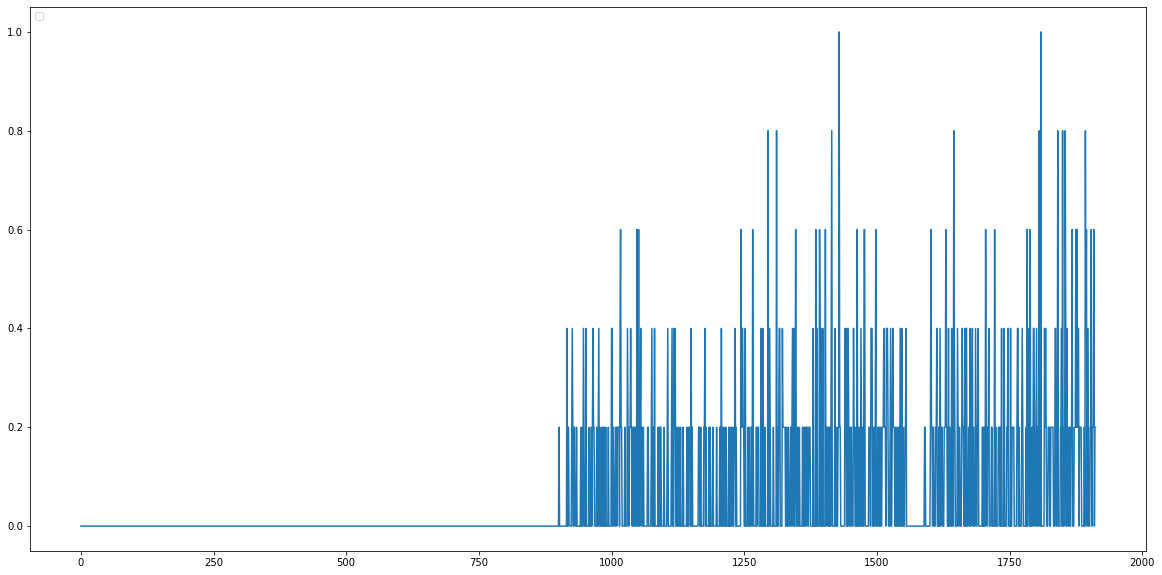

In [212]:
itemNum = 0
sales1 = npNorm[itemNum]
# sales1 = df.iloc[itemNum,1250:]

# label1 = [df.iloc[itemNum,0]]

plt.figure(figsize=(20,10))
plt.plot(sales1)
plt.legend(loc='upper left')
plt.show()

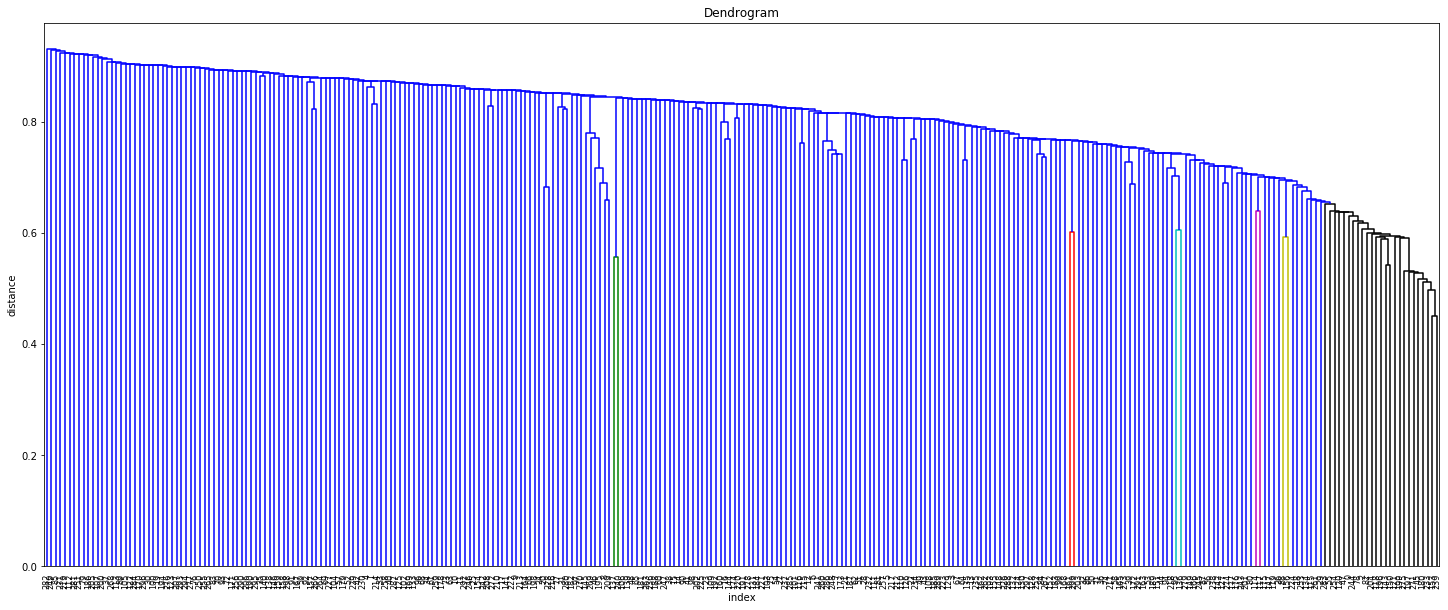

In [219]:
Z = hac.linkage(npNorm[:300], method='single', metric='correlation')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
hac.dendrogram(Z, leaf_rotation=90, leaf_font_size=8)

plt.show()

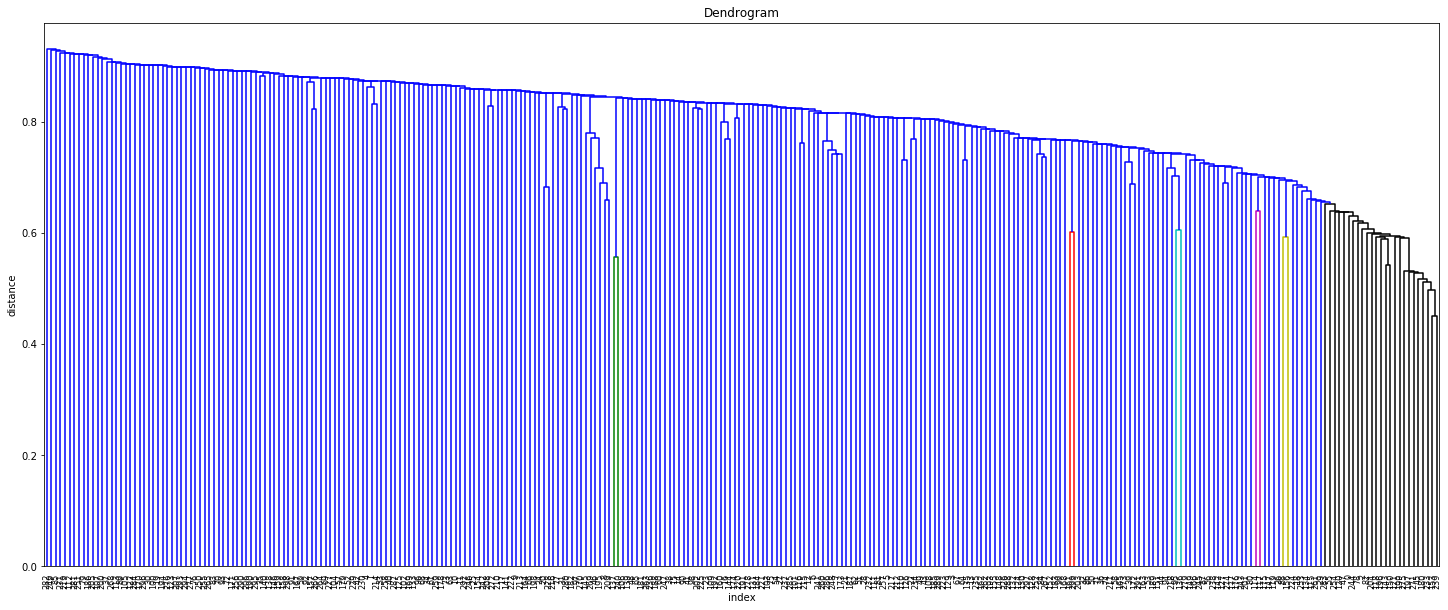

In [222]:
# spearman correlation
def spearmancorr(x, y):
    r = stats.pearsonr(x, y)[0]
    return(1 - r) # correlation to distance: range 0 to 2

# clustering    
Z = hac.linkage(npNorm[:300],  method='single', metric=spearmancorr)

# dendogram
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
hac.dendrogram(Z, leaf_rotation=90, leaf_font_size=8)

plt.show()

In [79]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(npNorm, Z, k):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))

numClusters = 6
print_clusters(npNorm, Z, 6)



Cluster 1 number of entries 195
Cluster 4 number of entries 1
Cluster 5 number of entries 1
Cluster 3 number of entries 1
Cluster 6 number of entries 1
Cluster 2 number of entries 1


In [85]:
# get clusters

numClusters = 6

clusterList = fcluster(Z, numClusters, criterion='maxclust')

print(clusterList)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [99]:
asdf = pd.DataFrame(clusterList, columns=['cluster'])
asdf.index[asdf['cluster']==6]

Int64Index([107], dtype='int64')

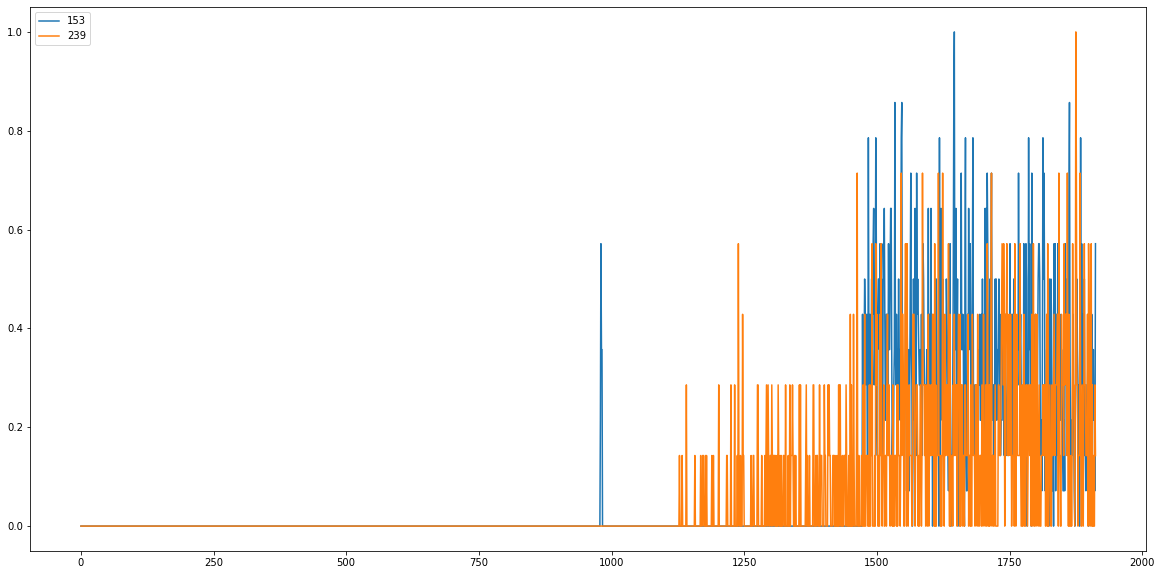

In [224]:

plt.figure(figsize=(20,10))
plt.plot(npNorm[153], label='153')
plt.plot(npNorm[239], label='239')
plt.legend(loc='upper left')
plt.show()